# Visualizing how data processing and activation functions effect the gradient

This notebook is from me messing around with various data distributions, normalization techniques, and activation functions to give myself a more intuitive understanding of how the shape of the gradient changes with each alteration. It's also for my own future reference if i ever forget and need to revisit

In [ ]:
!pip install plotly

In [ ]:
import plotly.express as px
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_2d(x_data, y_data, x_label='X-axis', y_label='Y-axis', title='2D Plot', xlim=None, ylim=None):
    plt.scatter(x_data, y_data)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.show()
def plot_3d_scatter(df, title='Gradient w.r.t parameters'):
    fig = px.scatter_3d(df, x='w', y='b', z='l', title=title)
    fig.update_layout(scene=dict(xaxis_title='weight', yaxis_title='bias', zaxis_title='loss'))
    fig.show()

Just generating our dataset here, literally just a linear function with one predictor variable

In [ ]:
#x = np.array([[1,2,3,4,5,6,7]])
num_examples = 50
num_features = 1
mean = 3
stdev = 1
x = np.random.normal(mean, stdev, (num_features,num_examples))
true_weight = 5
true_bias = 5
noise = 1.5
y = np.matmul(np.array([true_weight,true_bias]), np.concatenate((x, np.ones(num_examples)[None,:]))) + np.random.normal(0, noise, num_examples)

def calculate_loss(w_b, x, y):
  #more rows in x = more columns in w_b
  #w_b is of shape [[w1, b1],
  #                 [w2, b2]...]
  #or n_w by num_parameters
  X = np.concatenate((x, np.ones(x.shape[1])[None,:]))
  #X is of shape [[x1, x2, x3...], [1, 1, 1...]]
  #or num_parameters by n_X

  z = np.matmul(w_b, X)
  y_hat = z
  # y_hat = np.maximum(0, z) #applies ReLU
  error = y_hat - np.tile(y,w_b.shape[0]).reshape(y_hat.shape)

  squared_error = np.square(error)

  sum_squared_error = np.sum(squared_error, 1)

  mean_squared_error = sum_squared_error/x.shape[1]

  return(mean_squared_error)

In [ ]:
w_b = np.random.uniform(-100, 100, size=(500,2))
#concatenating a 100 by 2 with a 1 by 2 along dimension 1
w_b = np.concatenate((w_b, np.array([5,5])[None,:]))

# Visualizing gradient surface with no normalization whatsoever

This is the shape of our data, plotting response vs. predictor

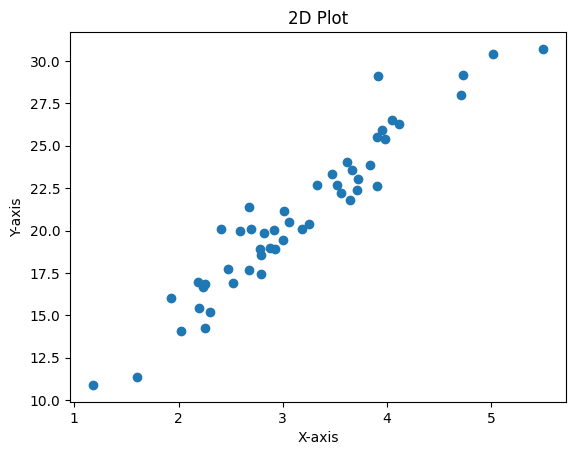

In [ ]:
examples = x
targets = y
plot_2d(examples, targets)

If we now build a single layer perceptron. we can visualize the shape of the gradient as we move through the different weights and biases

In [ ]:
losses = calculate_loss(w_b, examples, targets)
DF = pd.DataFrame(np.concatenate((losses[:, None], w_b), axis=1), columns = ['l', 'w', 'b'])
plot_3d_scatter(DF, 'Gradient without normalization')

Because input distribution is non-zero centered with a positive bias, the partial derivative for the weight and the bias will always share the same sign of being either positive or negative given that the activation function is also non-zero centered. IE: consider that the partial derivative for the weight depends only on the partial derivative of loss with respect to the activation--if we are using an activation function which is also non-zero centered such as ReLU or sigmoid, or in our case no activation at all (same as ReLU for activated values greater than 0), then the sign for our partial derivative will depend only on the loss and the given input example. Since our input distribution skews positively, more often than not, this then only leaves the loss to factor into consideration, which is identical to the partial derivative expression for bias. Hence, whenever we are using non-zero centered data with a non-zero centered activation function, gradient descent will be restricted in the directions it can travel in. In the two dimensional case as shown, this means the [+, +] direction and the [-, -] direction.

Avoiding nasty gradient curves like these is why normalizing our features is very important

# Minmax normaliation on inputs with -0.5 shift

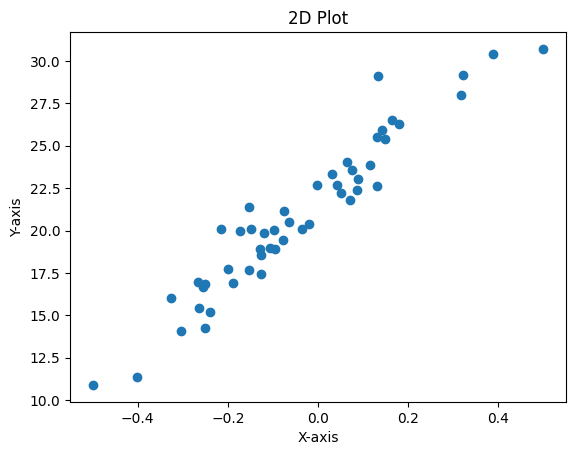

In [ ]:
examples = (x-np.min(x))/(np.max(x)-np.min(x)) - 0.5
targets = y
plot_2d(examples, targets)

In [ ]:
print(f'min: {np.min(examples)}')
print(f'max: {np.max(examples)}')
print(f'mean: {np.mean(examples)}')
print(f'median: {np.median(examples)}')

min: -0.5
max: 0.5
mean: -0.04350712244942602
median: -0.07575217671492263


In [ ]:
losses = calculate_loss(w_b, examples, targets)
DF = pd.DataFrame(np.concatenate((losses[:, None], w_b), axis=1), columns = ['l', 'w', 'b'])
plot_3d_scatter(DF, 'Gradient with input minmax normalization')

In [ ]:
examples.sum()

-2.175356122471301

It's not enough on its own to normalize our data with some arbitrary algorithm. In this case, despite minmax normalization with a -0.5 shift providing us with a new feature space that seems zero-centered, the distribution of the new feature space is actually skewing negatively and we are still left with a gradient space in which descent is restricted--in this case descent is restricted to the [+,-] and [-, +] directions.  

# Batch normalization on inputs

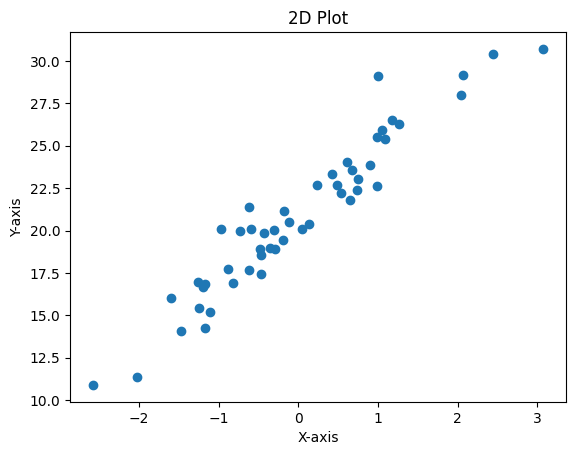

In [ ]:
examples = (x-np.mean(x))/np.var(x)
targets = y
plot_2d(examples, targets)

In [ ]:
losses = calculate_loss(w_b, examples, targets)
DF = pd.DataFrame(np.concatenate((losses[:, None], w_b), axis=1), columns = ['l', 'w', 'b'])
plot_3d_scatter(DF, 'Gradient with input batch normalization')

Alas, we end up with the nice, textbook shape gradient after proper normalizations

# Batch normalization on inputs and outputs


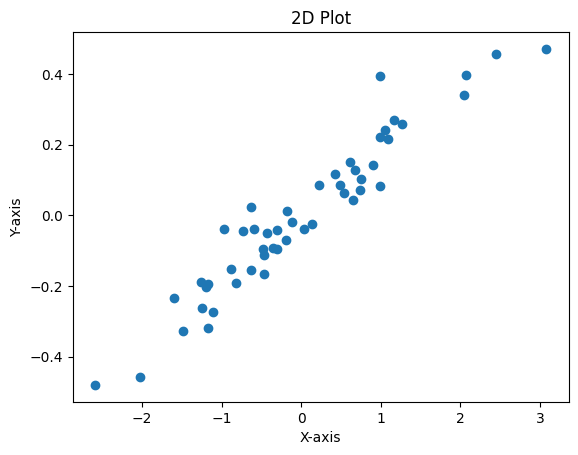

In [ ]:
examples = (x-np.mean(x))/np.var(x)
targets = (y-np.mean(y))/np.var(y)
plot_2d(examples, targets)

In [ ]:
losses = calculate_loss(w_b, examples, targets)
DF = pd.DataFrame(np.concatenate((losses[:, None], w_b), axis=1), columns = ['l', 'w', 'b'])
plot_3d_scatter(DF, 'Gradient with input batch normalization')